**Задача**  
Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**  
course_project_train.csv - обучающий датасет  
course_project_test.csv - тестовый датасет

**Целевая переменная**  
Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**  
F1-score (sklearn.metrics.f1_score)

**Требования к решению**   
F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

#### Описание датасета

**Home Ownership** - домовладение  
**Annual Income** - годовой доход  
**Years in current job** - количество лет на текущем месте работы  
**Tax Liens** - налоговые обременения  
**Number of Open Accounts** - количество открытых счетов  
**Years of Credit History** - количество лет кредитной истории  
**Maximum Open Credit** - наибольший открытый кредит  
**Number of Credit Problems** - количество проблем с кредитом  
**Months since last delinquent** - количество месяцев с последней просрочки платежа  
**Bankruptcies** - банкротства  
**Purpose** - цель кредита  
**Term** - срок кредита  
**Current Loan Amount** - текущая сумма кредита  
**Current Credit Balance** - текущий кредитный баланс  
**Monthly Debt** - ежемесячный долг  
**Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

**Пути к директориям и файлам**

In [5]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'
PREDICTIONS_PATH = 'Zolotykh_Nikolay_predictions.csv'

### Обзор обучающего датасета

**Загрузка данных**

In [6]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)

In [7]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Размер обучающего датасета**

In [8]:
df_train.shape

(7500, 17)

**Количество и типы данных**

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

**Целевая переменная**

In [10]:
target_name = 'Credit Default'

In [11]:
df_train[target_name].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

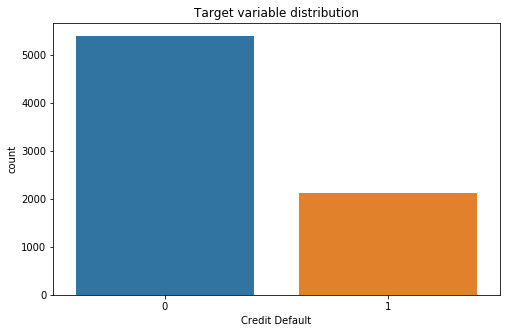

In [12]:
plt.figure(figsize=(8, 5))

sns.countplot(x=target_name, data=df_train)

plt.title('Target variable distribution')
plt.show()

**Обзор количественных признаков**

In [13]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


**Обзор номинативных признаков**

In [14]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

**Обработка пропусков и выбросов**

In [15]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

**Заполним пропуски столбца 'Annual Income' медианным значением**

In [16]:
df_train['Annual Income'].fillna(df_train['Annual Income'].median(), inplace=True)
df_train['Annual Income'].isna().sum()

0

**Заполним пропуски столбца 'Years in current job' модой**

In [17]:
df_train['Years in current job'].fillna(df_train['Years in current job'].mode()[0], inplace=True)
df_train['Years in current job'].isna().sum()

0

**По столбцу 'Months since last delinquent' пропусков больше половины. Пока уберем его совсем**

In [18]:
df_train = df_train.drop('Months since last delinquent', axis=1)

**Заполним пропуски столбца 'Bankruptcies' модой**

In [19]:
df_train['Bankruptcies'].fillna(df_train['Bankruptcies'].mode()[0], inplace=True)
df_train['Bankruptcies'].isna().sum()

0

**В тестовом датасете у признака 'Purpose' отсутствует категория 'renewable energy'. Таким образом, после создания dummy переменных в обучающем датасете будет на один признак больше. С учетом количества кредитов 2шт на 'renewable energy', посчитал, что данная категория не окажет значимого влияния на качество предсказаний и просто отнес записи с ней в другую категорию 'other'**

In [20]:
df_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [21]:
df_train['Purpose'].loc[df_train['Purpose']=='renewable energy'] = 'other' 

**Помотрим на признак 'Current Loan Amount'**

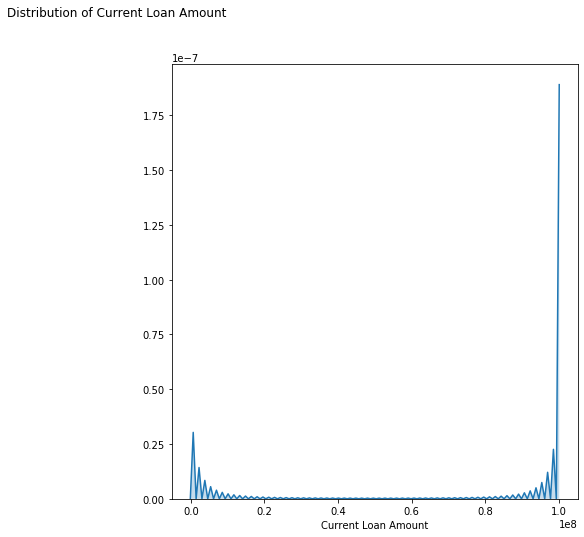

In [22]:
plt.figure(figsize = (16, 8))

plt.subplot(122)
sns.kdeplot(df_train['Current Loan Amount'], shade=True, legend=False)
plt.xlabel('Current Loan Amount')

plt.suptitle('Distribution of Current Loan Amount')
plt.show()

##### Скачок в районе 100 млн выглядит странно

In [23]:
df_train['Current Loan Amount'].max()

99999999.0

##### Более того, это еще и самое часто встречающеея значение

In [24]:
df_train['Current Loan Amount'].mode()

0    99999999.0
dtype: float64

##### Похоже, что это какое-то стандартное заведомо большое значение размера кредита для заполнения случаев, когда истинная сумма неизвестна

In [25]:
df_train['Current Loan Amount'].loc[df_train['Current Loan Amount']==99999999.0].count()

870

##### Расцениваю это как выбросы и с учетом количества таких примеров, считаю что они могут повлиять на итоговые предсказания. Поэтому заменяю их на медиану.

In [26]:
df_train['Current Loan Amount'].loc[df_train['Current Loan Amount']==99999999.0] = df_train['Current Loan Amount'].median() 

**Заполним пропуски столбца 'Credit Score' медианным значением**

In [27]:
df_train['Credit Score'].fillna(df_train['Credit Score'].median(), inplace=True)
df_train['Credit Score'].isna().sum()

0

**Обработка категориальных признаков и создание dummy переменных**

In [28]:
df_train['Term'] = df_train['Term'].map({'Long Term':'1', 'Short Term':'0'}).astype(int)

In [29]:
df_train['Years in current job'] = df_train['Years in current job'].map({
                                                                        '10+ years':'100', 
                                                                        '< 1 year':'0',
                                                                        '1 year':'1',    
                                                                        '2 years':'2',
                                                                        '3 years':'3',
                                                                        '4 years':'4',
                                                                        '5 years':'5',
                                                                        '6 years':'6',
                                                                        '7 years':'7',
                                                                        '8 years':'8',
                                                                        '9 years':'9'}).astype(int)

In [30]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)

In [31]:
df_train = df_train.drop(df_train.select_dtypes(include='object').columns, axis=1)

In [32]:
df_train.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Term,Current Loan Amount,...,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,482087.0,100,0.0,11.0,26.3,685960.0,1.0,1.0,0,309573.0,...,0,0,0,0,0,0,0,0,0,0
1,1025487.0,100,0.0,15.0,15.3,1181730.0,0.0,0.0,1,264968.0,...,0,0,0,0,0,0,0,0,0,0
2,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,0.0,0,309573.0,...,0,0,0,0,0,0,0,0,0,0
3,805068.0,6,0.0,8.0,22.5,147400.0,1.0,1.0,0,121396.0,...,0,0,0,0,0,0,0,0,0,0
4,776264.0,8,0.0,13.0,13.6,385836.0,1.0,0.0,0,125840.0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
target_name = 'Credit Default'
feature_names = df_train.columns.drop(target_name).tolist()

In [34]:
feature_names

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_vacation',
 'Purpose_wedding']

**Разбиваем на обучающую и валидационную выборку**

In [35]:
X = df_train[feature_names]
y = df_train[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=True, random_state=42)

**Сбалансируем целевую переменную с использованием class_weight**

In [36]:
model_rf = RandomForestClassifier(class_weight={0: 1, 1: 2.55}, random_state=42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 2.55},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [37]:
y_train_pred = model_rf.predict(X_train)
y_test_pred = model_rf.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      4074
           1       1.00      0.93      0.96      1551

    accuracy                           0.98      5625
   macro avg       0.99      0.96      0.97      5625
weighted avg       0.98      0.98      0.98      5625

TEST

              precision    recall  f1-score   support

           0       0.76      0.95      0.84      1313
           1       0.72      0.28      0.41       562

    accuracy                           0.75      1875
   macro avg       0.74      0.62      0.62      1875
weighted avg       0.74      0.75      0.71      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1250   63
1                403  159


**Теперь подберем гиперпараметры**

In [38]:
params = {'n_estimators':[50, 100, 200, 500], 
          'max_depth':[3, 5, 7, 10]}

In [39]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [40]:
rs = RandomizedSearchCV(model_rf, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight={0: 1,
                                                                  1: 2.55},
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_lea

In [41]:
rs.best_params_

{'n_estimators': 100, 'max_depth': 7}

In [42]:
rs.best_score_

0.5292493249304605

**Финальный вариант с class_weight и найденными гиперпараметрами**

In [70]:
model_rf = RandomForestClassifier(n_estimators = 100, max_depth = 7, class_weight={0: 1, 1: 2.55}, random_state = 42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 2.55},
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [71]:
y_train_pred = model_rf.predict(X_train)
y_test_pred = model_rf.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4074
           1       0.64      0.61      0.62      1551

    accuracy                           0.80      5625
   macro avg       0.74      0.74      0.74      5625
weighted avg       0.79      0.80      0.79      5625

TEST

              precision    recall  f1-score   support

           0       0.80      0.83      0.82      1313
           1       0.57      0.51      0.54       562

    accuracy                           0.74      1875
   macro avg       0.68      0.67      0.68      1875
weighted avg       0.73      0.74      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1093  220
1                276  286


**Обученим финальную модель на полной выборке**

In [45]:
model_rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 2.55},
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

### Обзор тестового датасета

**Загрузка данных**

In [46]:
df_test = pd.read_csv(TEST_DATASET_PATH)

In [47]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


**Размер тестового датасета**

In [48]:
df_test.shape

(2500, 16)

**Количество и типы данных**

In [49]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Home Ownership                  2500 non-null object
Annual Income                   1987 non-null float64
Years in current job            2414 non-null object
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    1142 non-null float64
Bankruptcies                    2497 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    1987 non-null float64
dtypes: float64(12), object(4)
me

**Обзор количественных признаков**

In [50]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


**Обзор номинативных признаков**

In [51]:
for cat_colname in df_test.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_test[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving               

**Обработка пропусков и выбросов**

In [52]:
len(df_test) - df_test.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

**Заполним пропуски столбца 'Annual Income' медианным значением**

In [53]:
df_test['Annual Income'].fillna(df_test['Annual Income'].median(), inplace=True)
df_test['Annual Income'].isna().sum()

0

**Заполним пропуски столбца 'Years in current job' модой**

In [54]:
df_test['Years in current job'].fillna(df_test['Years in current job'].mode()[0], inplace=True)
df_test['Years in current job'].isna().sum()

0

**По столбцу 'Months since last delinquent' пропусков больше половины. Уберем его совсем**

In [55]:
df_test = df_test.drop('Months since last delinquent', axis=1)

**Заполним пропуски столбца 'Bankruptcies' модой**

In [56]:
df_test['Bankruptcies'].fillna(df_test['Bankruptcies'].mode()[0], inplace=True)
df_test['Bankruptcies'].isna().sum()

0

**Выбросы 'Current Loan Amount'**

In [57]:
df_test['Current Loan Amount'].loc[df_test['Current Loan Amount']==99999999.0] = df_test['Current Loan Amount'].median()

**Заполним пропуски столбца 'Credit Score' медианным значением**

In [58]:
df_test['Credit Score'].fillna(df_test['Credit Score'].median(), inplace=True)
df_test['Credit Score'].isna().sum()

0

**Обработка категориальных признаков и создание dummy переменных**

In [59]:
df_test['Term'] = df_test['Term'].map({'Long Term':'1', 'Short Term':'0'}).astype(int)

In [60]:
df_test['Years in current job'] = df_test['Years in current job'].map({
                                                                        '10+ years':'100', 
                                                                        '< 1 year':'0',
                                                                        '1 year':'1',    
                                                                        '2 years':'2',
                                                                        '3 years':'3',
                                                                        '4 years':'4',
                                                                        '5 years':'5',
                                                                        '6 years':'6',
                                                                        '7 years':'7',
                                                                        '8 years':'8',
                                                                        '9 years':'9'}).astype(int)

In [61]:
for cat_colname in df_test.select_dtypes(include='object').columns:
    df_test = pd.concat([df_test, pd.get_dummies(df_test[cat_colname], prefix=cat_colname)], axis=1)

In [62]:
df_test = df_test.drop(df_test.select_dtypes(include='object').columns, axis=1)

**Предсказания по тестовой выборке**

In [63]:
feature_names = df_test.columns.tolist()

In [64]:
y_pred = model_rf.predict(df_test[feature_names])

**Сохраняем результаты**

In [65]:
df_test['Credit Default'] = y_pred
df_test.to_csv(PREDICTIONS_PATH, columns=['Credit Default'], index=True, encoding='utf-8')